In [3]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
import pandas as pd
import sklearn.model_selection
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

Using TensorFlow backend.


In [4]:
def stringToDateTime(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return dt.datetime.strptime(datetime, '%Y-%m-%d %H:%M:%S')

In [5]:
def datetimeToFloat(columns):
    d=columns[0]
    return d.timestamp()

In [6]:
def extractMonth(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return datetime.month

In [7]:
def extractdayOfWeek(columns):
    date=columns[0]
    if pd.isnull(date):
        return date
    else:
        return date.weekday()

In [8]:
def extractday(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return datetime.day

In [9]:
def datetimeToFloat(columns):
    d=columns[0]
    return d.timestamp()

In [10]:
def formatDate(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return str(datetime.day)+'/'+str(datetime.month)+'/'+str(datetime.year)

In [11]:
#Read the data
data=pd.read_csv('1.csv', delimiter='\t')

In [12]:
#Check the number of data and its datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 2 columns):
time       517 non-null object
Visitor    517 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.2+ KB


In [13]:
#Check the number of null values
data.isnull().sum()

time       0
Visitor    0
dtype: int64

In [14]:
#Convert date string to datetime object
data['time']=data[['time']].apply(stringToDateTime,axis=1)

In [15]:
#Extract day from datetime
data['day']=data[['time']].apply(extractday,axis=1)

In [16]:
#Extract month
data['month']=data[['time']].apply(extractMonth,axis=1)

In [17]:
#Extract day of the week
data['dayOfWeek']=data[['time']].apply(extractdayOfWeek,axis=1)

In [18]:
#Format the datetime for graph
data['formattedDate']=data[['time']].apply(formatDate,axis=1)

In [19]:
#Convert the datetime to time from epoch time
data['time']=data[['time']].apply(datetimeToFloat,axis=1)

In [20]:
#Create dummy variables for categorical day of the week
dayOfWeekDumyList = pd.get_dummies(data['dayOfWeek'], prefix='dayOfWeek')
data=data.join(dayOfWeekDumyList)
data=data.drop('dayOfWeek',axis=1)

In [21]:
#Create dummy variables for categorical month
monthDumyList = pd.get_dummies(data['month'], prefix='month')
data=data.join(monthDumyList)
data=data.drop('month',axis=1)

In [22]:
#Create dummy variables for categorical day
dayDumyList = pd.get_dummies(data['day'], prefix='day')
data=data.join(dayDumyList)
data=data.drop('day',axis=1)

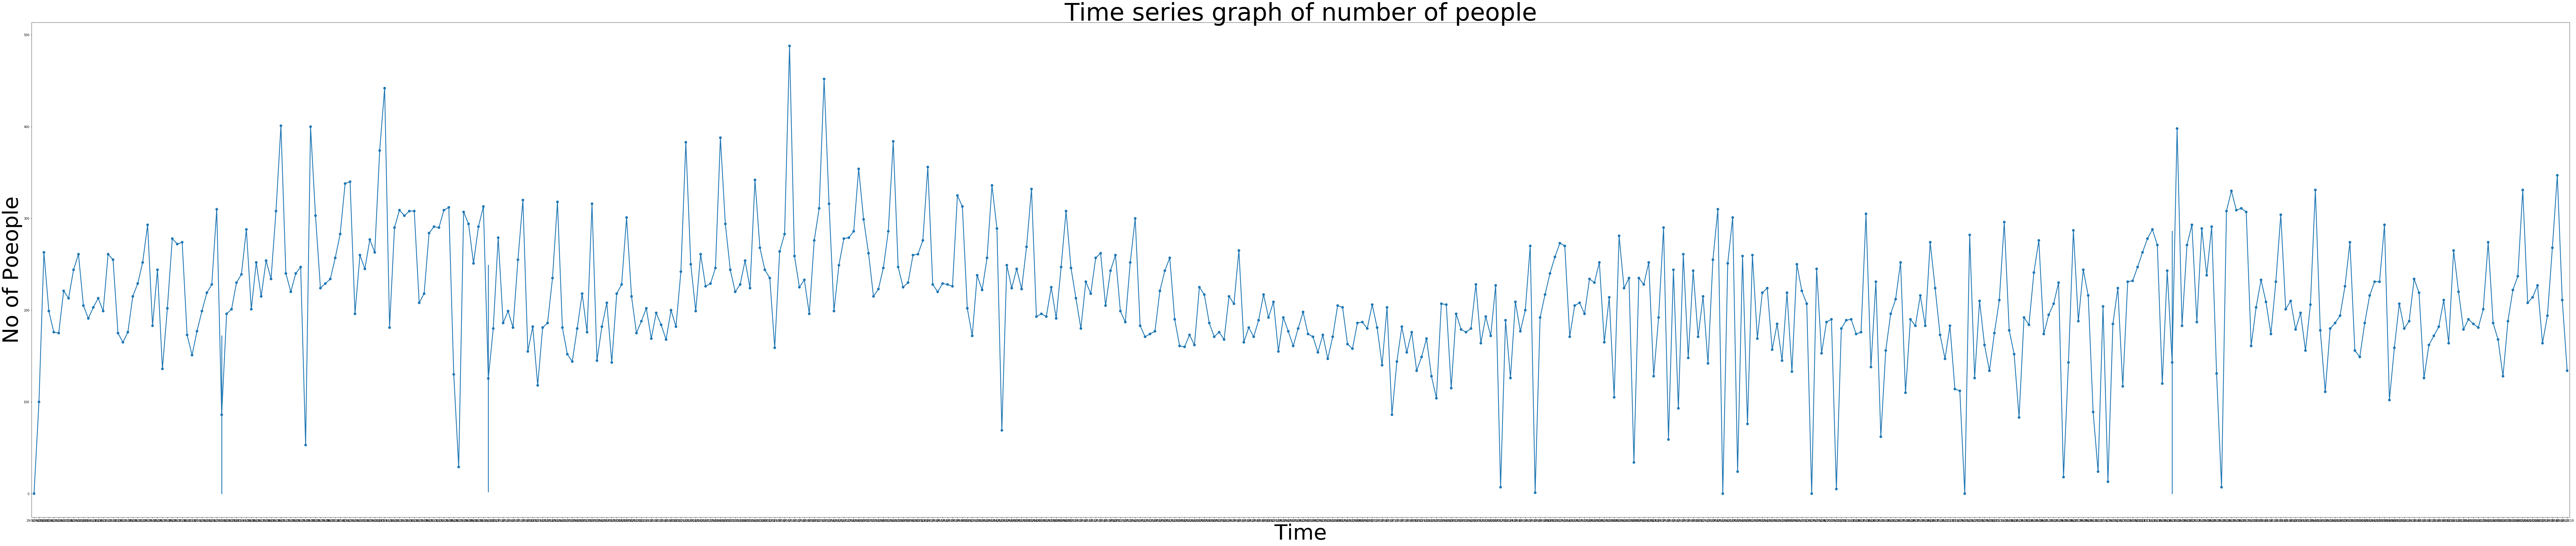

In [23]:
#Plot the graph No of people against Time
mpl.rcParams['figure.figsize']=150,30
fig=sns.pointplot(x='formattedDate',y='Visitor',data=data)
fig.set_xlabel('Time',fontsize=70)
fig.set_ylabel('No of Poeople',fontsize=70)
fig.axes.set_title('Time series graph of number of people',fontsize=80)
plt.show()

In [24]:
#Drop time and formatted date from the data
data=data.drop('time',axis=1)
data=data.drop('formattedDate',axis=1)

In [25]:
'''X_train, X_test = train_test_split(data, test_size=0.2)
X_train=X_train.values
X_test=X_test.values
X_train.shape'''

'X_train, X_test = train_test_split(data, test_size=0.2)\nX_train=X_train.values\nX_test=X_test.values\nX_train.shape'

In [26]:
#Normalise data to 0 to 1 range
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [27]:
#Split training and testing data
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
X_train, X_test = pd.DataFrame(data[0:train_size,:]), pd.DataFrame(data[train_size:len(data),:])
X_train=X_train.values
X_test=X_test.values
X_train.shape

(413, 51)

In [28]:
#Reshape training and testing data for LSTM(2 to 3 dimension)
X_train=X_train.reshape(len(X_train),1,X_train.shape[-1])
X_test=X_test.reshape(len(X_test),1,X_test.shape[-1])

In [46]:
X_train.shape[-1]

51

In [30]:
#Define the dimension,batch size and epochs of neural network
original_dim=X_train.shape[-1]
first_dim=int((3*original_dim)/4)
second_dim=int((3*first_dim)/4)
third_dim=int((3*second_dim)/4)

timesteps = X_train.shape[1]
batch_size = 1
latent_dim=2
epochs = 25
epsilon_std=1.0

In [31]:
#Encoder layer definition
input_layer = Input(shape=(timesteps,original_dim, ))
encoder = LSTM(first_dim,return_sequences=True,activation='tanh')(input_layer)
encoder = LSTM(second_dim,return_sequences=True,activation='tanh')(encoder)
encoder = LSTM(third_dim,return_sequences=True,activation='tanh')(encoder)
encoder = LSTM(latent_dim,activation='tanh')(encoder)

In [32]:
#Repeat the data using Repeat Vector to convert 2 to 3 dimension for LSTM input
decoder=RepeatVector(timesteps)(encoder)

In [33]:
#Decoder layer definition
decoder = LSTM(third_dim,return_sequences=True,activation='tanh')(decoder)
decoder = LSTM(second_dim,return_sequences=True,activation='tanh')(decoder)
decoder = LSTM(first_dim,return_sequences=True,activation='tanh')(decoder)
decoder = LSTM(original_dim,return_sequences=True,activation='tanh')(decoder)

In [34]:
#Create the auto encoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [35]:
#Display the summary of auto encoder
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 51)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 38)             13680     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 28)             7504      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 21)             4200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 2)                 192       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 2)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 21)             2016      
__________

In [36]:
#Encoder model to plot and check the distribution in latent space
encoderModel = Model(input_layer, encoder)

In [37]:
#Compile the created auto encoder model
autoencoder.compile(optimizer='rmsprop', 
                    loss='mean_squared_error')

In [38]:
#Convert all the data to float and rehshape again
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.reshape((len(X_train),1, np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test),1, np.prod(X_test.shape[1:])))

In [39]:
#Fit or Run the model
autoencoder.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/25
413/413 [==============================] - 6s 14ms/step - loss: 0.0569
Epoch 2/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0549
Epoch 3/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0548
Epoch 4/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0541
Epoch 5/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0526
Epoch 6/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0512
Epoch 7/25
413/413 [==============================] - 5s 11ms/step - loss: 0.0499
Epoch 8/25
413/413 [==============================] - 4s 11ms/step - loss: 0.0479
Epoch 9/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0460
Epoch 10/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0443
Epoch 11/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0429
Epoch 12/25
413/413 [==============================] - 4s 10ms/step - loss: 0.0418
Epoch 13/25
4

In [40]:
#Predict values based on test dataset
preds=autoencoder.predict(X_test, batch_size=batch_size)

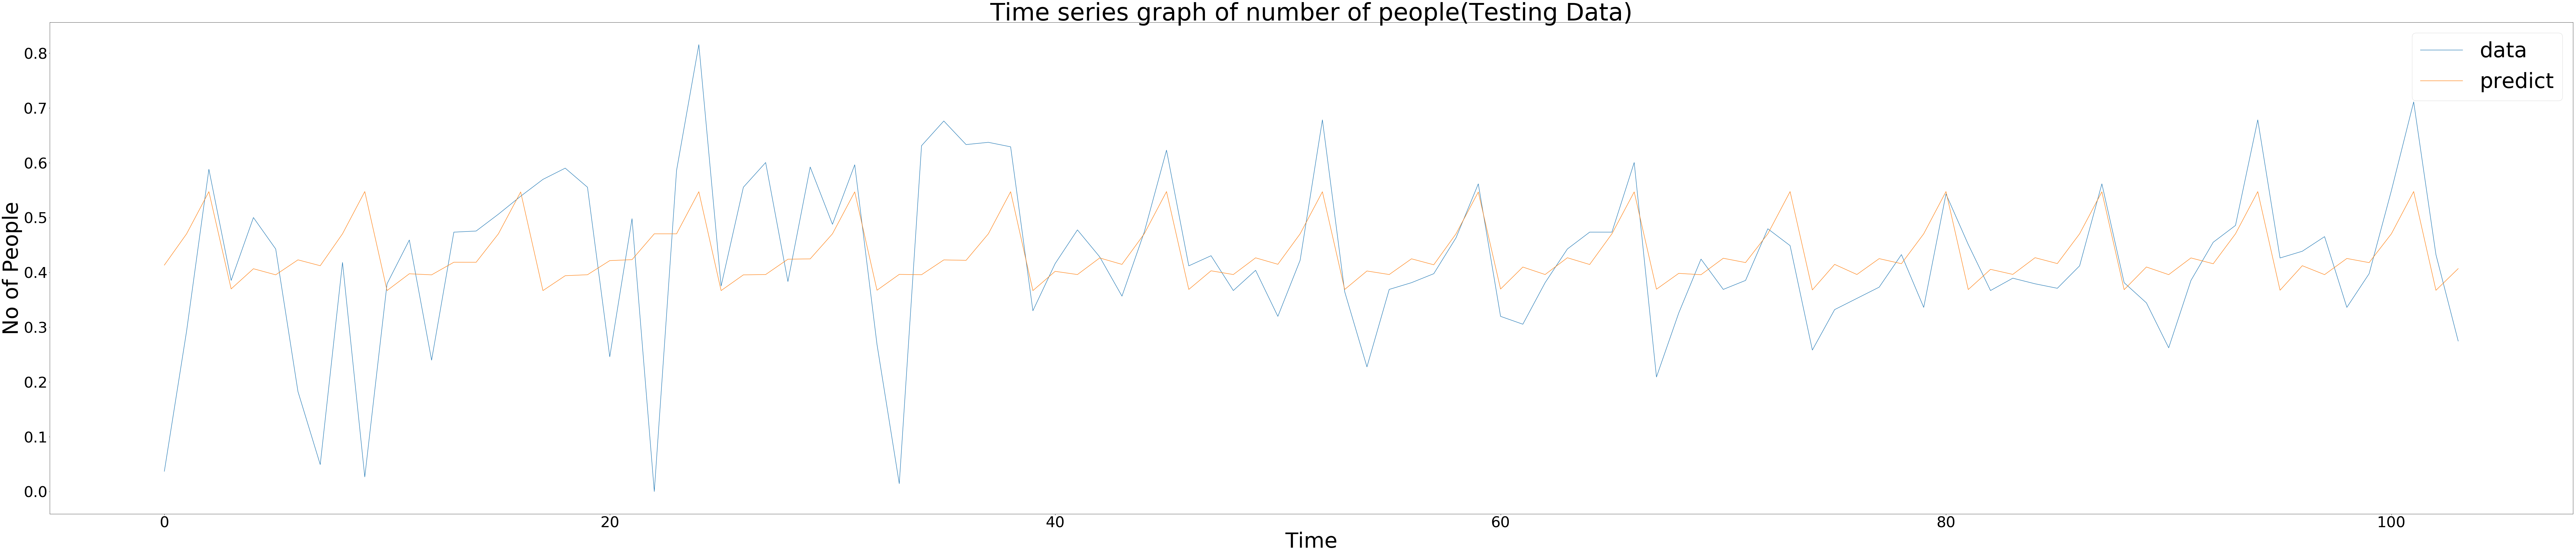

In [41]:
#Plot test dataset and predicted dataset based on test dataset
plt.plot(X_test[:,0,0], label='data')
plt.plot(preds[:,0,0], label='predict')
plt.xlabel('Time',fontsize=70)
plt.ylabel('No of People',fontsize=70)
plt.tick_params(labelsize=50)
plt.title('Time series graph of number of people(Testing Data)',fontsize=80)
plt.legend(fontsize=70)
plt.show()

In [42]:
#Predict values based on train dataset
preds=autoencoder.predict(X_train, batch_size=batch_size)

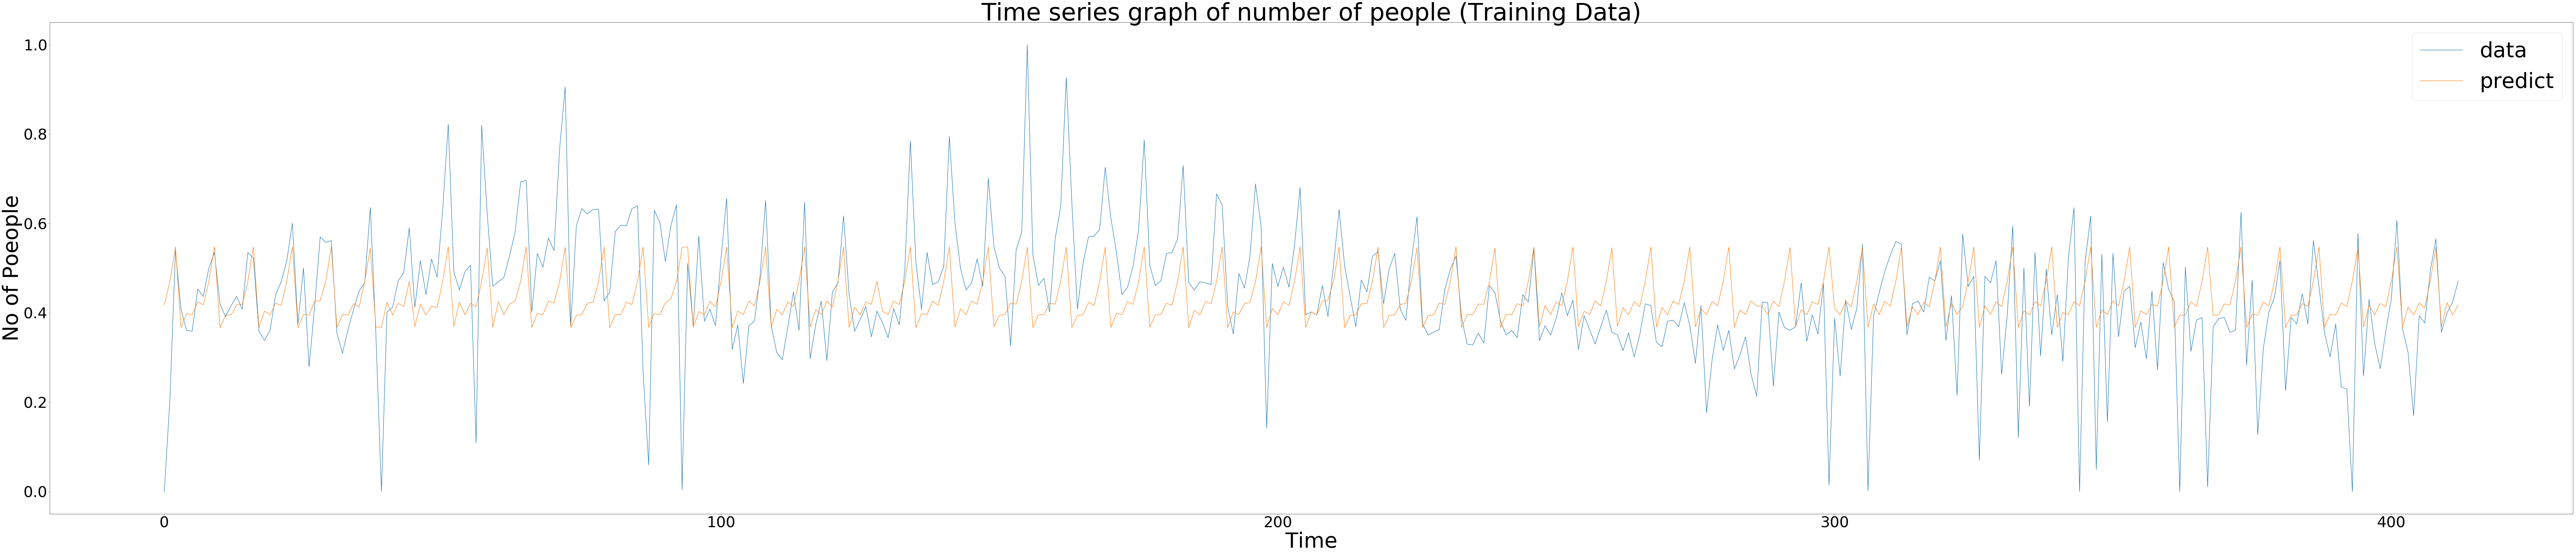

In [43]:
#Plot test dataset and predicted dataset based on train dataset
plt.plot(X_train[:,0,0], label='data')
plt.plot(preds[:,0,0], label='predict')
plt.xlabel('Time',fontsize=70)
plt.ylabel('No of Poeople',fontsize=70)
plt.tick_params(labelsize=50)
plt.title('Time series graph of number of people (Training Data)',fontsize=80)
plt.legend(fontsize=70)
plt.show()